In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, ReLU, LeakyReLU, Dense, Activation, MaxPooling2D
import cv2
from sklearn.utils import shuffle
import os
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Set memory growth for each GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs.")
    except RuntimeError as e:
        # Memory growth must be set before initializing GPUs
        print(f"Error setting memory growth: {e}")

Memory growth enabled for GPUs.


In [3]:
class_names = os.listdir('./seg_train/seg_train/')

In [4]:
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [5]:
class_names_labels = {class_name: i for i, class_name in enumerate(class_names)}

In [6]:
class_names_labels

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [7]:
nb_classes = len(class_names)
IMAGE_SIZE = (150,150)

Load Data

In [8]:
class_names_labels

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [9]:
def load_data():
    datasets = ['./seg_train/seg_train', './seg_test/seg_test']
    output  = []
    
    for dataset in datasets:
        images = []
        labels = []
        
        print(f'Loading {dataset}')
        
        for folder in os.listdir(dataset):
            label = class_names_labels[folder]
            
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)
                
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype='float32')
        labels = np.array(labels, dtype='int32')
        
        output.append((images, labels))
    
    return output

In [10]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading ./seg_train/seg_train


100%|██████████| 2382/2382 [00:02<00:00, 1059.16it/s]


Loading ./seg_test/seg_test


100%|██████████| 501/501 [00:00<00:00, 1049.52it/s]


In [11]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=42)

In [12]:
train_labels

array([0, 5, 5, ..., 2, 0, 3])

In [13]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

In [14]:
print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (150, 150)


In [15]:
train_images.shape

(14034, 150, 150, 3)

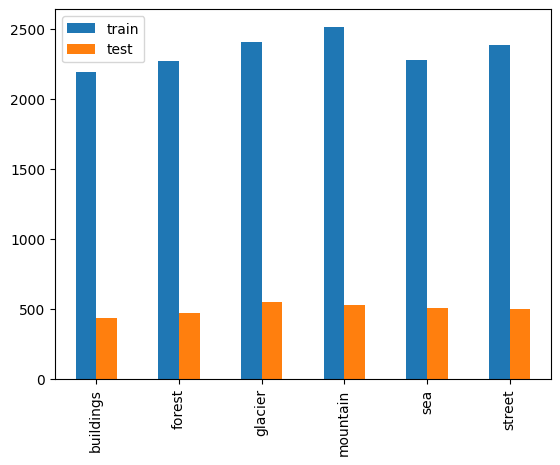

In [16]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
              'test': test_counts}, index=class_names).plot.bar()
plt.show()

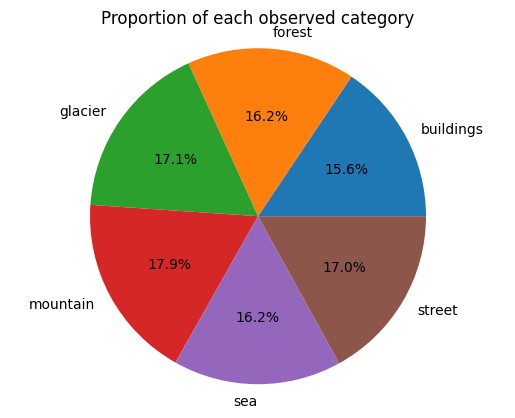

In [17]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [18]:
train_images

array([[[[250., 250., 250.],
         [251., 251., 251.],
         [250., 250., 250.],
         ...,
         [254., 254., 254.],
         [254., 254., 254.],
         [255., 255., 255.]],

        [[211., 211., 211.],
         [213., 213., 213.],
         [214., 214., 214.],
         ...,
         [242., 242., 242.],
         [242., 242., 242.],
         [242., 242., 242.]],

        [[225., 225., 225.],
         [226., 226., 226.],
         [227., 227., 227.],
         ...,
         [240., 240., 240.],
         [240., 240., 240.],
         [239., 239., 239.]],

        ...,

        [[142., 141., 139.],
         [181., 180., 178.],
         [118., 117., 115.],
         ...,
         [136., 134., 135.],
         [ 94.,  92.,  95.],
         [ 80.,  78.,  81.]],

        [[158., 157., 155.],
         [162., 161., 159.],
         [149., 148., 146.],
         ...,
         [140., 139., 137.],
         [111., 109., 110.],
         [ 19.,  17.,  18.]],

        [[ 86.,  85.,  83.],
       

In [19]:
train_images = train_images/255.0
test_images = test_images/255.0

In [20]:
def display_random_image(class_names, images, labels):
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(f'Image #{index}' + class_names[labels[index]])
    plt.show()

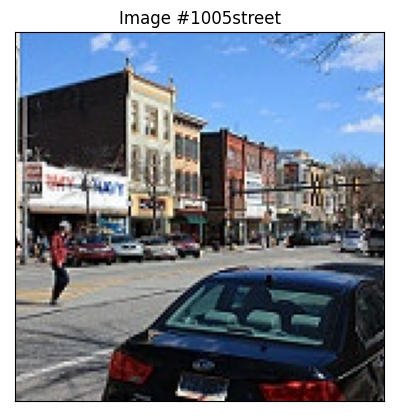

In [21]:
display_random_image(class_names, train_images, train_labels)

In [22]:
def display_examples(class_names, images, labels):

    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

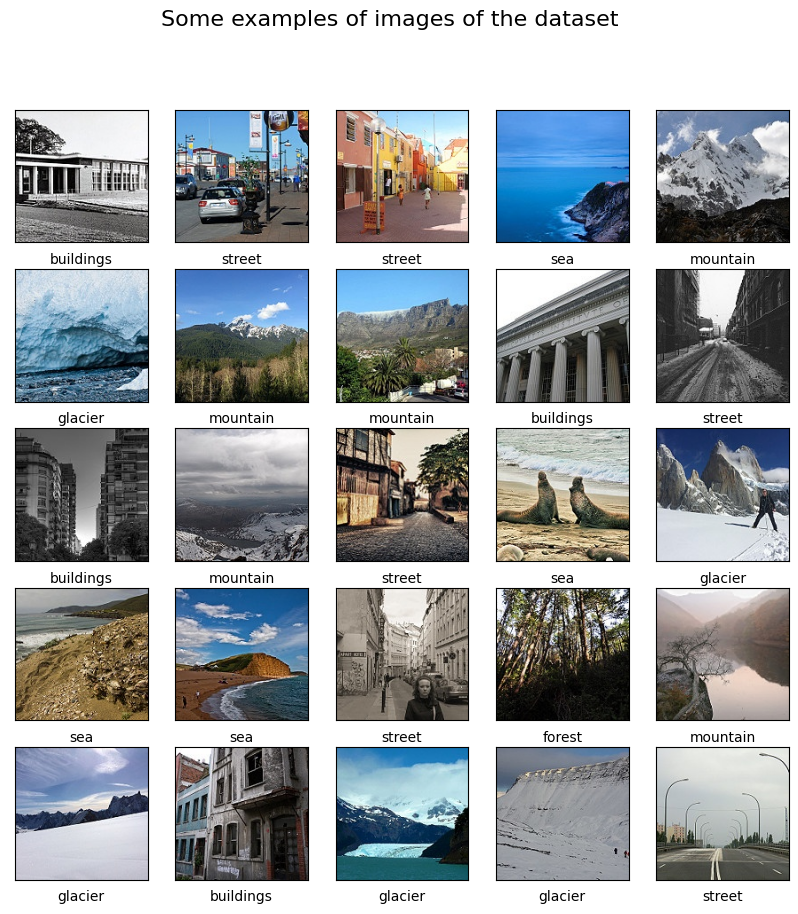

In [23]:
display_examples(class_names, train_images, train_labels)

In [24]:
from tensorflow.keras.layers import BatchNormalization, Dropout

In [25]:
def cnn():
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), input_shape = (150,150,3)))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dropout(0.2))
    model.add(LeakyReLU(0.15))
    
    model.add(Conv2D(64, (3,3)))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dropout(0.2))
    model.add(LeakyReLU(0.15)) 
    
    model.add(Conv2D(128, (3, 3))) 
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dropout(0.2))
    model.add(LeakyReLU(0.15))  
    
    model.add(Flatten())
    model.add(Dense(128))
    model.add(ReLU())
    model.add(Dense(6, activation='softmax'))    
    
    return model

In [26]:
model = cnn()

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 74, 74, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 32)        0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0

In [28]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [29]:
history = model.fit(
    train_images,
    train_labels,
    batch_size=128, 
    epochs=20, 
    validation_split=0.2
)

Epoch 1/20
88/88 [==============================] - 28s 193ms/step - loss: 1.9791 - accuracy: 0.5167 - val_loss: 1.4091 - val_accuracy: 0.4849
Epoch 2/20
88/88 [==============================] - 6s 67ms/step - loss: 0.6994 - accuracy: 0.7426 - val_loss: 0.7542 - val_accuracy: 0.7296
Epoch 3/20
88/88 [==============================] - 6s 68ms/step - loss: 0.5453 - accuracy: 0.8007 - val_loss: 0.7695 - val_accuracy: 0.7300
Epoch 4/20
88/88 [==============================] - 6s 68ms/step - loss: 0.4577 - accuracy: 0.8350 - val_loss: 0.8735 - val_accuracy: 0.6883
Epoch 5/20
88/88 [==============================] - 6s 67ms/step - loss: 0.3999 - accuracy: 0.8533 - val_loss: 0.6848 - val_accuracy: 0.7556
Epoch 6/20
88/88 [==============================] - 6s 69ms/step - loss: 0.3422 - accuracy: 0.8751 - val_loss: 0.5912 - val_accuracy: 0.7909
Epoch 7/20
88/88 [==============================] - 6s 66ms/step - loss: 0.2918 - accuracy: 0.8958 - val_loss: 0.7477 - val_accuracy: 0.7560
Epoch 8/20


In [30]:
def plot_accuracy_loss(history):
    fig = plt.figure(figsize=(10,5))
    
    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

In [31]:
history.history

{'loss': [1.9790796041488647,
  0.6994128823280334,
  0.5453209280967712,
  0.4576507806777954,
  0.3998653292655945,
  0.3422148823738098,
  0.2918257415294647,
  0.2553965449333191,
  0.21627740561962128,
  0.16880610585212708,
  0.14862829446792603,
  0.1225476861000061,
  0.11400292068719864,
  0.11550155282020569,
  0.10246714949607849,
  0.09046834707260132,
  0.07684250921010971,
  0.07494040578603745,
  0.07951011508703232,
  0.05245882645249367],
 'accuracy': [0.516700804233551,
  0.7425848245620728,
  0.8007481694221497,
  0.8350405097007751,
  0.8533000946044922,
  0.8751224875450134,
  0.8957869410514832,
  0.911196231842041,
  0.9216175079345703,
  0.9412131309509277,
  0.9495857954025269,
  0.961521327495575,
  0.9628574252128601,
  0.9597399234771729,
  0.9663311839103699,
  0.9700721502304077,
  0.9770196676254272,
  0.9760398864746094,
  0.9733677506446838,
  0.9835218787193298],
 'val_loss': [1.4091026782989502,
  0.7542335391044617,
  0.7694994211196899,
  0.87345045

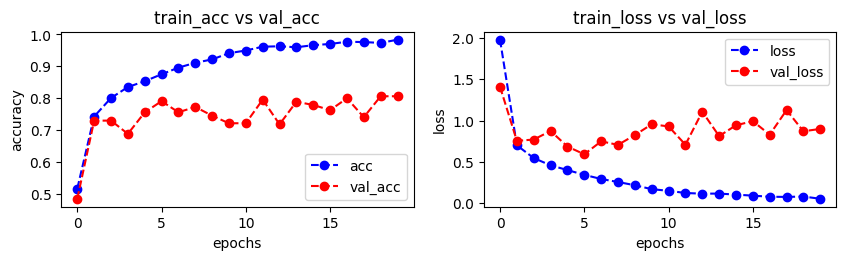

In [32]:
plot_accuracy_loss(history)

In [ ]:
prediction = model.predict(test_images)
pred_label = np.argmax(prediction, axis=1)

In [35]:
pred_label = np.argmax(prediction, axis=1)

In [36]:
predictions = prediction

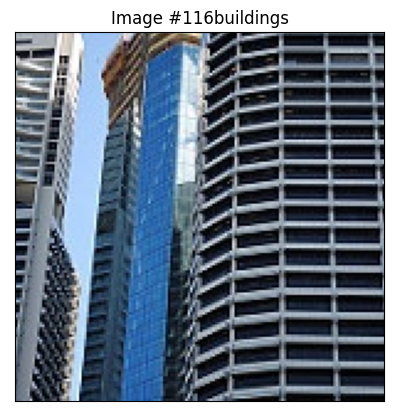

In [37]:
display_random_image(class_names, test_images, pred_label)

In [38]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):

    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

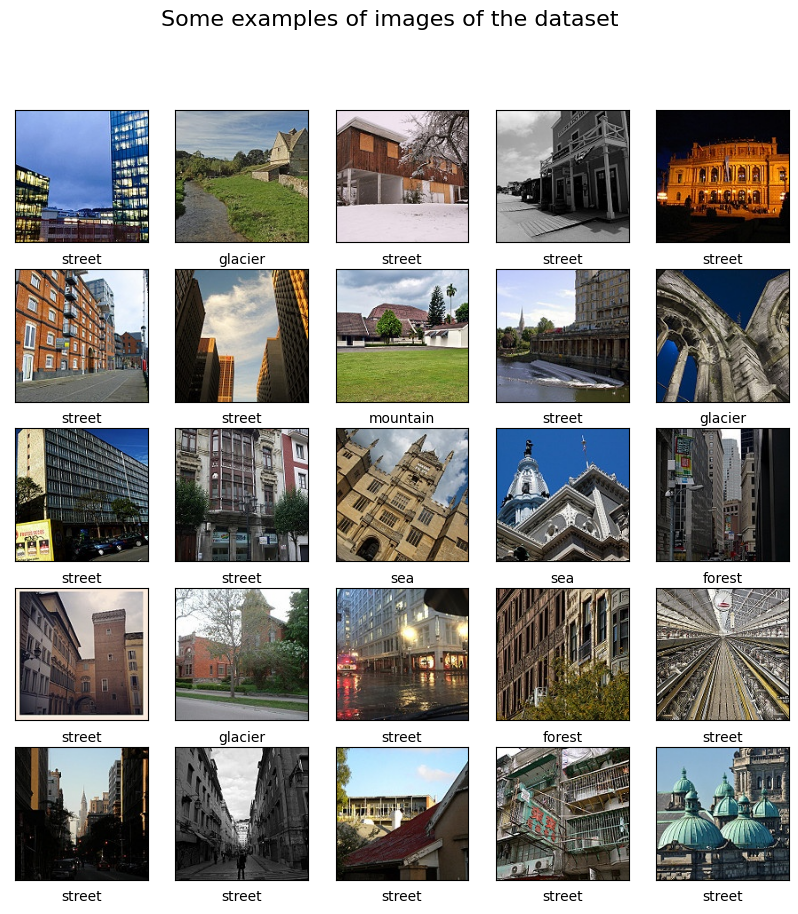

In [40]:
print_mislabeled_images(class_names, test_images, test_labels, pred_label)

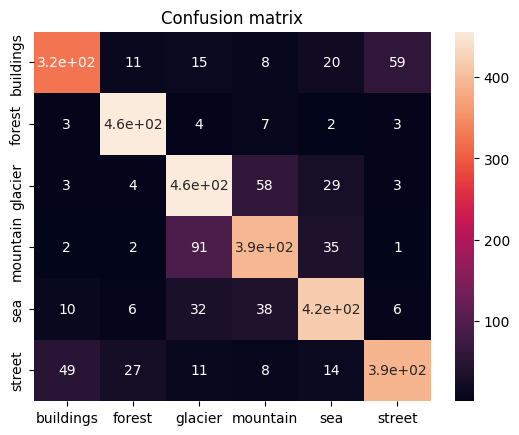

In [42]:
CM = confusion_matrix(test_labels, pred_label)
ax = plt.axes()
sns.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

VGG 


In [43]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input

model = VGG19(weights='imagenet', include_top=False)


In [44]:
# tf.keras.backend.clear_session()

In [45]:
train_features = model.predict(train_images, batch_size=16)
test_features = model.predict(test_images, batch_size=16)

In [46]:
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z

In [47]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = train_features.reshape((n_train, x*y*z))
pca.fit(X)

C = pca.transform(X)
C1 = C[:,0]
C2 = C[:,1]

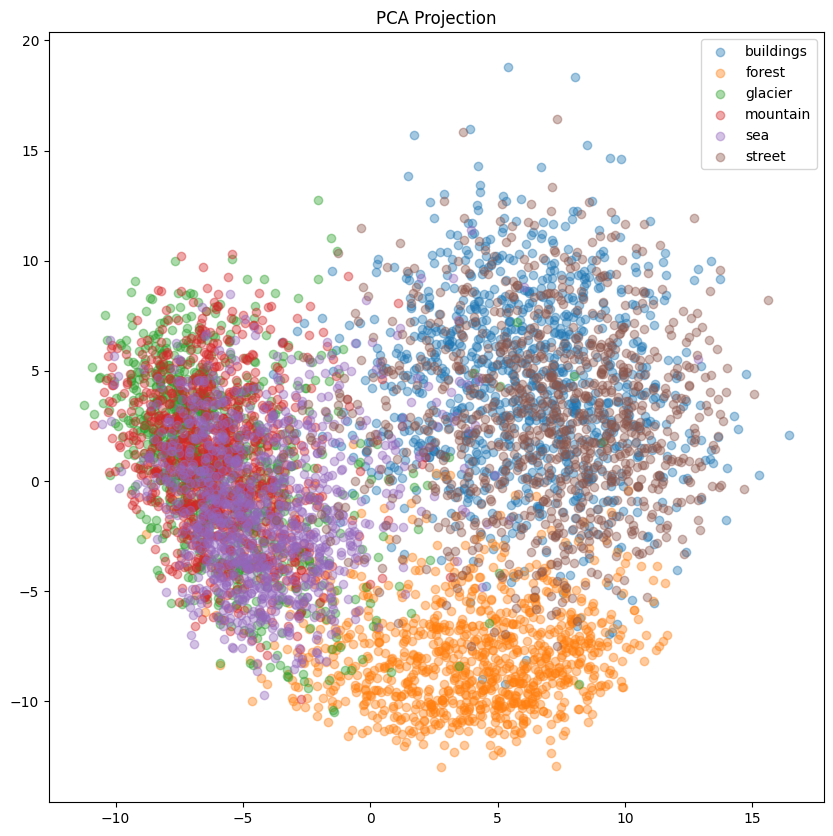

In [48]:
plt.subplots(figsize=(10,10))

for i, class_name in enumerate(class_names):
    plt.scatter(C1[train_labels == i][:1000], C2[train_labels == i][:1000], label = class_name, alpha=0.4)
plt.legend()
plt.title("PCA Projection")
plt.show()

In [49]:
model2 = tf.keras.Sequential([
    Flatten(input_shape = (x, y, z)),
    Dense(50, activation=tf.nn.relu),
    Dense(6, activation=tf.nn.softmax)
])

model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(train_features, train_labels, batch_size=128, epochs=15, validation_split = 0.2)

Epoch 1/15
88/88 [==============================] - 1s 4ms/step - loss: 0.7170 - accuracy: 0.7392 - val_loss: 0.4553 - val_accuracy: 0.8354
Epoch 2/15
88/88 [==============================] - 0s 3ms/step - loss: 0.3725 - accuracy: 0.8676 - val_loss: 0.3965 - val_accuracy: 0.8593
Epoch 3/15
88/88 [==============================] - 0s 3ms/step - loss: 0.3100 - accuracy: 0.8912 - val_loss: 0.4045 - val_accuracy: 0.8511
Epoch 4/15
88/88 [==============================] - 0s 3ms/step - loss: 0.2758 - accuracy: 0.9002 - val_loss: 0.3513 - val_accuracy: 0.8753
Epoch 5/15
88/88 [==============================] - 0s 3ms/step - loss: 0.2385 - accuracy: 0.9165 - val_loss: 0.3591 - val_accuracy: 0.8767
Epoch 6/15
88/88 [==============================] - 0s 3ms/step - loss: 0.2161 - accuracy: 0.9250 - val_loss: 0.3609 - val_accuracy: 0.8764
Epoch 7/15
88/88 [==============================] - 0s 3ms/step - loss: 0.1930 - accuracy: 0.9322 - val_loss: 0.3591 - val_accuracy: 0.8750
Epoch 8/15
88/88 [==

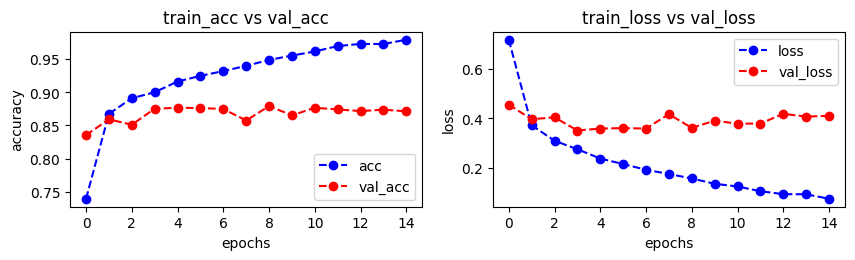

In [50]:
plot_accuracy_loss(history2)

In [51]:
test_loss = model2.evaluate(test_features, test_labels)

94/94 [==============================] - 0s 3ms/step - loss: 0.3957 - accuracy: 0.8730


In [52]:
np.random.seed(seed=1997)
n_estimators = 10
max_samples = 0.8

max_samples *= n_train
max_samples = int(max_samples)

In [53]:
models = list()
random = np.random.randint(50, 100, size = n_estimators)

for i in range(n_estimators):
    
    # Model
    model = tf.keras.Sequential([ tf.keras.layers.Flatten(input_shape = (x, y, z)),
                                # One layer with random size
                                    tf.keras.layers.Dense(random[i], activation=tf.nn.relu),
                                    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
                                ])
    
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Store model
    models.append(model)

In [54]:
models

In [55]:
histories = []

for i in range(n_estimators):
    # Train each model on a bag of the training data
    train_idx = np.random.choice(len(train_features), size = max_samples)
    histories.append(models[i].fit(train_features[train_idx], train_labels[train_idx], batch_size=128, epochs=10, validation_split = 0.1))

Epoch 1/10
79/79 [==============================] - 1s 5ms/step - loss: 0.5863 - accuracy: 0.7810 - val_loss: 0.3561 - val_accuracy: 0.8691
Epoch 2/10
79/79 [==============================] - 0s 3ms/step - loss: 0.3014 - accuracy: 0.8980 - val_loss: 0.3233 - val_accuracy: 0.8825
Epoch 3/10
79/79 [==============================] - 0s 3ms/step - loss: 0.2347 - accuracy: 0.9246 - val_loss: 0.2648 - val_accuracy: 0.9038
Epoch 4/10
79/79 [==============================] - 0s 3ms/step - loss: 0.1885 - accuracy: 0.9404 - val_loss: 0.2475 - val_accuracy: 0.9136
Epoch 5/10
79/79 [==============================] - 0s 3ms/step - loss: 0.1558 - accuracy: 0.9518 - val_loss: 0.2229 - val_accuracy: 0.9181
Epoch 6/10
79/79 [==============================] - 0s 3ms/step - loss: 0.1217 - accuracy: 0.9655 - val_loss: 0.2173 - val_accuracy: 0.9270
Epoch 7/10
79/79 [==============================] - 0s 4ms/step - loss: 0.1059 - accuracy: 0.9706 - val_loss: 0.2133 - val_accuracy: 0.9261
Epoch 8/10
79/79 [==

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [56]:
predictions = []
for i in range(n_estimators):
    predictions.append(models[i].predict(test_features))
    
predictions = np.array(predictions)
predictions = predictions.sum(axis = 0)
pred_labels = predictions.argmax(axis=1)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [57]:
predictions

[array([[9.9865735e-01, 3.0346945e-07, 9.2218812e-05, 1.6172825e-06,
         1.9368857e-04, 1.0547234e-03],
        [9.3723482e-01, 3.2120501e-05, 8.4428910e-05, 2.3306957e-07,
         9.1548747e-04, 6.1732918e-02],
        [9.9999356e-01, 4.1723869e-09, 3.9310480e-06, 1.7381497e-08,
         2.3741022e-06, 8.4544432e-08],
        ...,
        [1.2227199e-03, 8.2039839e-04, 9.7325724e-04, 3.4938913e-02,
         9.4699770e-01, 1.5046965e-02],
        [9.7103298e-01, 1.4277225e-07, 5.3829302e-05, 4.4795295e-05,
         1.2086151e-03, 2.7659640e-02],
        [5.8371334e-05, 1.2444902e-06, 4.2472686e-07, 5.4011227e-09,
         1.6105218e-05, 9.9992383e-01]], dtype=float32),
 array([[9.9979383e-01, 1.9447267e-10, 6.5213758e-06, 1.8549841e-07,
         1.8581650e-06, 1.9763339e-04],
        [5.1558137e-01, 6.8299742e-06, 2.5796711e-05, 1.0447369e-06,
         4.7942380e-05, 4.8433697e-01],
        [9.9995732e-01, 2.2957330e-11, 1.6597400e-07, 5.8519318e-09,
         3.5607169e-05, 6.936

In [59]:
from sklearn.metrics import accuracy_score
print("Accuracy : {}".format(accuracy_score(test_labels, pred_label)))

Accuracy : 0.813
